In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


In [2]:
data_dir_train = "/kaggle/input/skin-disease-dataset/Skin_Disease_Dataset/Train"
data_dir_test = "/kaggle/input/skin-disease-dataset/Skin_Disease_Dataset/Test"
data_dir_val = "/kaggle/input/skin-disease-dataset/Skin_Disease_Dataset/Val"


In [3]:
# data_dir_train = "/kaggle/input/vegetable-image-dataset/Vegetable Images/test"
# data_dir_test = "/kaggle/input/vegetable-image-dataset/Vegetable Images/train"

In [4]:

# Data transformations
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Datasets
train_dataset = datasets.ImageFolder(root=data_dir_train, transform=data_transforms["train"])
val_dataset = datasets.ImageFolder(root=data_dir_val, transform=data_transforms["val"])
test_dataset = datasets.ImageFolder(root=data_dir_test, transform=data_transforms["test"])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Class information
class_names = train_dataset.classes
num_classes = len(class_names)

print(f"Classes: {class_names}")
print(f"Number of classes: {num_classes}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")


Classes: ['1. Eczema', '10. Warts Molluscum and other Viral Infections', '2. Melanoma', '3. Atopic Dermatitis', '4. Basal Cell Carcinoma (BCC)', '5. Melanocytic Nevi (NV)', '6. Benign Keratosis-like Lesions (BKL)', '7. Psoriasis pictures Lichen Planus and related diseases', '8. Seborrheic Keratoses and other Benign Tumors', '9. Tinea Ringworm Candidiasis and other Fungal Infections']
Number of classes: 10
Number of training samples: 19003
Number of validation samples: 2711
Number of test samples: 5439


In [5]:
print(class_names)
num_classes

['1. Eczema', '10. Warts Molluscum and other Viral Infections', '2. Melanoma', '3. Atopic Dermatitis', '4. Basal Cell Carcinoma (BCC)', '5. Melanocytic Nevi (NV)', '6. Benign Keratosis-like Lesions (BKL)', '7. Psoriasis pictures Lichen Planus and related diseases', '8. Seborrheic Keratoses and other Benign Tumors', '9. Tinea Ringworm Candidiasis and other Fungal Infections']


10

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


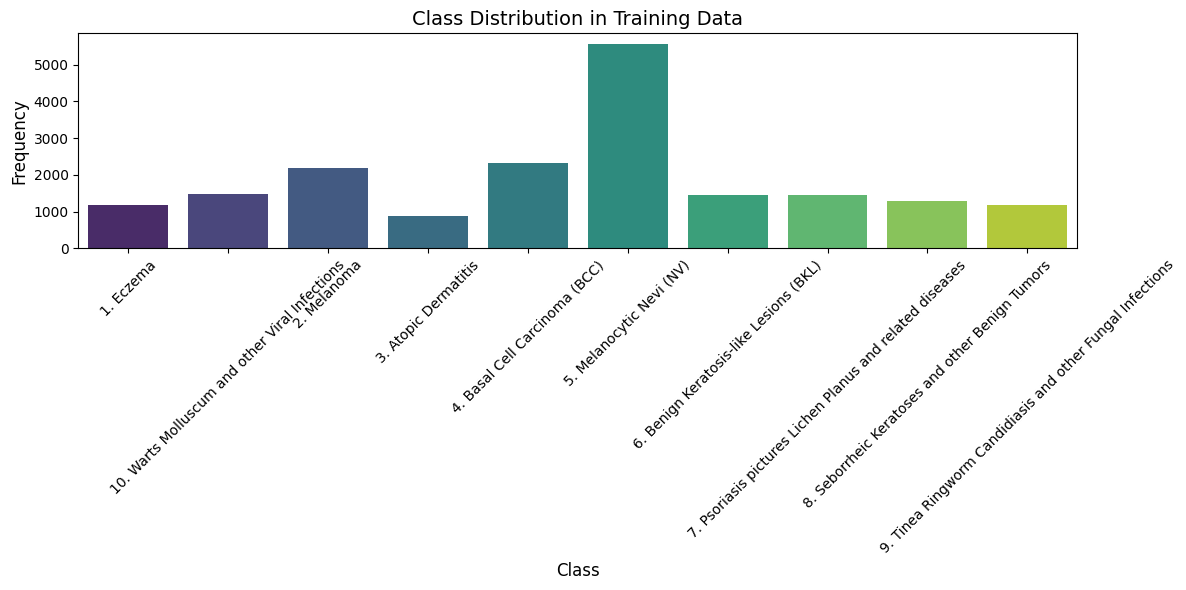

In [6]:
from collections import Counter

def plot_class_distribution(dataset, class_names):
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    class_indices = list(class_counts.keys())
    class_values = list(class_counts.values())
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=[class_names[idx] for idx in class_indices], y=class_values, palette="viridis")
    plt.title("Class Distribution in Training Data", fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_dataset, class_names)

In [7]:
from torch.utils.data import WeightedRandomSampler

# Tính trọng số mẫu
class_sample_counts = Counter([label for _, label in train_dataset])
weights = 1. / np.array([class_sample_counts[i] for i in range(num_classes)])
sample_weights = [weights[label] for _, label in train_dataset]

# Sampler
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=2)


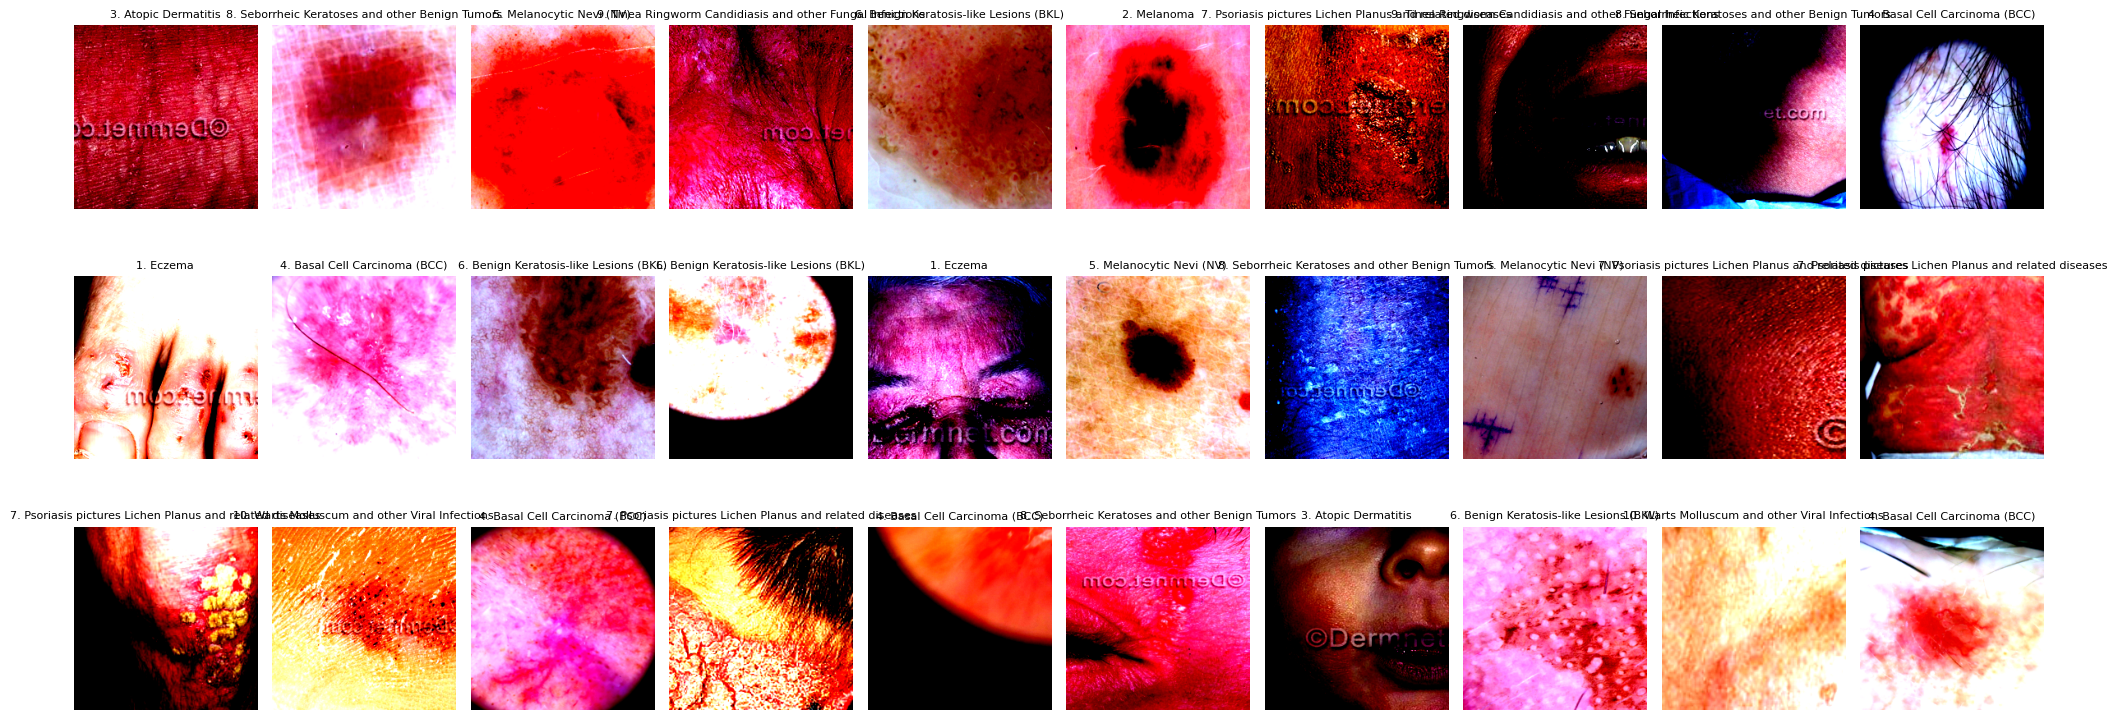

In [8]:

data_iter = iter(train_loader)
images, labels = next(data_iter)

# Hiển thị hình ảnh
fig, ax = plt.subplots(nrows=3, ncols=10, figsize=(20, 8))
for idx in range(30):
    row, col = divmod(idx, 10)
    ax[row, col].imshow(np.transpose(images[idx].numpy(), (1, 2, 0)))
    ax[row, col].set_title(str(class_names[labels[idx]]), fontsize=8)
    ax[row, col].axis('off')
plt.tight_layout()
plt.show()


In [9]:
# Tính trọng số cho các lớp
y_train = [label for _, labels in train_loader for label in labels.numpy()]
class_weights = compute_class_weight(class_weight="balanced", classes=np.arange(num_classes), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda")



In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
import torch
import torch.nn as nn

class VGG16PowerUp(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16PowerUp, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 5
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Tăng từ 128 lên 256
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),  # Giữ thông tin từ GAP
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )
        
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)  # Flatten sau GAP
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)  # Thay thế bằng Xavier Normal
                nn.init.constant_(m.bias, 0)

# Khởi tạo mô hình nâng cấp
num_classes 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_powerup = VGG16PowerUp(num_classes=num_classes).to(device)

def count_parameters(model):
    """Hàm đếm số tham số của mô hình."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# In số tham số
print(f"Số tham số sau khi tăng sức mạnh: {count_parameters(model_powerup):,}")


Số tham số sau khi tăng sức mạnh: 2,167,898


In [12]:
import os

# Tạo thư mục nếu chưa tồn tại
save_dir = "/kaggle/working/check"
os.makedirs(save_dir, exist_ok=True)

In [13]:
def train_and_evaluate_with_wandb(model, dataloaders, criterion, optimizer, device, num_epochs):
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []
    best_val_acc = 0.0  # Biến để lưu trữ giá trị val accuracy tốt nhất

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        wandb.log({"epoch": epoch + 1})
        
        # Pha train được thực hiện mọi epoch
        model.train()
        running_loss, running_corrects = 0.0, 0

        for batch_idx, (inputs, labels) in enumerate(dataloaders['train']):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                loss.backward()
                optimizer.step()

                #Tính Grad Norm
                total_norm = 0
                for p in model.parameters():
                    if p.grad is not None:
                        total_norm += p.grad.norm().item() ** 2
                total_norm = total_norm ** 0.5
                wandb.log({"grad_norm": total_norm})

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Log hình ảnh từ batch đầu tiên
            if batch_idx == 0:
                images = wandb.Image(inputs[:8].cpu(), caption="Ground Truth: {}".format(labels[:8].cpu()))
                wandb.log({"samples": images})

        # Tính toán loss và accuracy sau pha train
        train_loss = running_loss / len(dataloaders['train'].dataset)
        train_acc = running_corrects.double() / len(dataloaders['train'].dataset)

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc.item())
        wandb.log({
            "train_loss": train_loss,
            "train_accuracy": train_acc.item()
        })

        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        # Pha validation chỉ chạy mỗi 5 epoch
        if epoch % 5 == 4:
            model.eval()
            running_loss, running_corrects = 0.0, 0

            for batch_idx, (inputs, labels) in enumerate(dataloaders['val']):
                inputs, labels = inputs.to(device), labels.to(device)

                with torch.set_grad_enabled(False):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            # Tính toán loss và accuracy sau pha validation
            val_loss = running_loss / len(dataloaders['val'].dataset)
            val_acc = running_corrects.double() / len(dataloaders['val'].dataset)

            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc.item())
            wandb.log({
                "val_loss": val_loss,
                "val_accuracy": val_acc.item()
            })

            print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            # Kiểm tra và lưu mô hình nếu val accuracy cao nhất
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                model_path = f"/kaggle/working/best_model_vit_16_tiny_custom_epoch_{epoch + 1}.pth"  # Tên file có index của epoch
                torch.save(model.state_dict(), model_path)
                wandb.save(model_path)
                print(f"Best model saved at epoch {epoch + 1} with val accuracy {best_val_acc:.4f}")

    # Lưu mô hình cuối cùng vào Wandb
    torch.save(model.state_dict(), "final_model_custom.pth")
    wandb.save("final_model_pretrain.pth")
    print("Final model saved.")

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [24]:
import wandb
import timm

# Khởi tạo Wandb
wandb.init(
    project="skin-disease-classification",
    id="VGG-16-skin-fukhoan 6",
    config={
        "epochs": 5,
        "batch_size": 64,
        "learning_rate": 0.001,
        "optimizer": "Adam",
        "model": "vit_tiny_patch16_224",
        "num_classes": num_classes
    }
)


# Lấy config từ Wandb
config = wandb.config

# Thiết lập thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Khởi tạo mô hình và các thành phần
model = model_powerup.to(device)
# model = model_from_scratch_2
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
# Tạo dataloaders dictionary
dataloaders = {
    "train": train_loader,
    "val": val_loader
}


# checkpoint = torch.load("/kaggle/working/check/checkpoint4.pth", map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch = checkpoint['epoch']


epoch,▁▅█
grad_norm,▁▂▂▂▂▁▄▂▄▂▂▃▂▂▂▂▁▂▂▄▂▂▂▂▂▂▃▂▄▂▄▂▂▄▂▁▂▃█▁
train_accuracy,▁█
train_loss,█▁
epoch,3
grad_norm,3.64054
train_accuracy,0.46961
train_loss,1.29758


In [25]:
# Huấn luyện và đánh giá mô hình
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_and_evaluate_with_wandb(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=150
)


Epoch 1/150
Train Loss: 1.2673 Acc: 0.4957
Epoch 2/150
Train Loss: 1.2441 Acc: 0.5033
Epoch 3/150
Train Loss: 1.2048 Acc: 0.5187
Epoch 4/150
Train Loss: 1.2128 Acc: 0.5117
Epoch 5/150
Train Loss: 1.1962 Acc: 0.5228


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Val Loss: 0.9285 Acc: 0.6256
Best model saved at epoch 5 with val accuracy 0.6256
Epoch 6/150
Train Loss: 1.1735 Acc: 0.5315
Epoch 7/150
Train Loss: 1.1632 Acc: 0.5408
Epoch 8/150
Train Loss: 1.1443 Acc: 0.5432
Epoch 9/150
Train Loss: 1.1361 Acc: 0.5490
Epoch 10/150
Train Loss: 1.1337 Acc: 0.5500
Val Loss: 0.9184 Acc: 0.6381
Best model saved at epoch 10 with val accuracy 0.6381
Epoch 11/150
Train Loss: 1.1350 Acc: 0.5478
Epoch 12/150
Train Loss: 1.1139 Acc: 0.5557
Epoch 13/150
Train Loss: 1.0995 Acc: 0.5654
Epoch 14/150
Train Loss: 1.1001 Acc: 0.5686
Epoch 15/150
Train Loss: 1.0825 Acc: 0.5714
Val Loss: 1.1224 Acc: 0.5433
Epoch 16/150
Train Loss: 1.0809 Acc: 0.5765
Epoch 17/150
Train Loss: 1.0696 Acc: 0.5752
Epoch 18/150
Train Loss: 1.0710 Acc: 0.5785
Epoch 19/150
Train Loss: 1.0469 Acc: 0.5883
Epoch 20/150
Train Loss: 1.0423 Acc: 0.5919
Val Loss: 1.0013 Acc: 0.6149
Epoch 21/150
Train Loss: 1.0336 Acc: 0.5905
Epoch 22/150
Train Loss: 1.0282 Acc: 0.5978
Epoch 23/150
Train Loss: 1.0225 A

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, average_precision_score, confusion_matrix
import pandas as pd

def evaluate_on_test(model, test_loader, device, class_names):
    model.eval()  # Chuyển sang chế độ đánh giá
    all_preds = []
    all_labels = []
    all_probs = []

    print("Evaluating on test dataset...")
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Tính các chỉ số tổng thể
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(
        all_labels, 
        all_preds, 
        target_names=class_names, 
        digits=4, 
        output_dict=True
    )
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    # mAP (Mean Average Precision)
    binarized_labels = pd.get_dummies(all_labels).to_numpy()
    mAP = average_precision_score(binarized_labels, all_probs, average='macro')

    # Log các chỉ số tổng thể lên WandB
    wandb.log({
        "test_accuracy": accuracy,
        "test_precision_weighted": precision,
        "test_recall_weighted": recall,
        "test_f1_weighted": f1,
        "test_mAP": mAP
    })

    # Log các chỉ số theo từng lớp
    for class_name, metrics in report.items():
        if class_name in class_names:  # Chỉ log cho các lớp, bỏ qua "accuracy", "weighted avg", "macro avg"
            wandb.log({
                f"test_precision_{class_name}": metrics['precision'],
                f"test_recall_{class_name}": metrics['recall'],
                f"test_f1_{class_name}": metrics['f1-score']
            })

    # In các chỉ số tổng thể
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}, Recall (weighted): {recall:.4f}, F1-score (weighted): {f1:.4f}, mAP: {mAP:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    print("Confusion Matrix:")
    print(cm_df)
    wandb.log({"test_confusion_matrix": wandb.Table(dataframe=cm_df)})

    # Hiển thị một số mẫu đúng và sai
    print("\nSample Predictions:")
    correct_samples = [(i, p) for i, p in enumerate(zip(all_labels, all_preds)) if p[0] == p[1]]
    incorrect_samples = [(i, p) for i, p in enumerate(zip(all_labels, all_preds)) if p[0] != p[1]]

    print("Correct Predictions (first 5):")
    for idx, (true, pred) in correct_samples[:5]:
        print(f"Sample {idx}: True = {class_names[true]}, Pred = {class_names[pred]}")

    print("Incorrect Predictions (first 5):")
    for idx, (true, pred) in incorrect_samples[:5]:
        print(f"Sample {idx}: True = {class_names[true]}, Pred = {class_names[pred]}")

    return {
        "accuracy": accuracy,
        "precision_weighted": precision,
        "recall_weighted": recall,
        "f1_score_weighted": f1,
        "mAP": mAP,
        "class_metrics": report
    }


# Gọi evaluate_on_test sau khi huấn luyện
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
dataloaders["test"] = test_dataloader



# Đánh giá trên test set
test_metrics = evaluate_on_test(model, dataloaders["test"], device, class_names)
print(f"Test Set Metrics:\n{test_metrics}")
wandb.log({"test_metrics": test_metrics})
